**Author's LinkedIn:** [Matencio Montana](https://www.linkedin.com/in/montana-matencio-b01111376)  
**Contact:** [montana.matencio@gmail.com](mailto:montana.matencio@gmail.com)


**Stock Price Prediction using LSTM :**  
This project focuses on building and evaluating a deep learning model to predict the Adjusted Close price of IBM stock using historical data.

**Project Goal :**  
The primary objective is to develop a robust time series forecasting model that can predict future stock prices based on past observations.

**Technologies & Methodologies :**  
- Python: The core programming language.

- Pandas & NumPy: For data loading, manipulation, and numerical operations.

- Scikit-learn: For data preprocessing, specifically feature scaling (MinMaxScaler).

- PyTorch: The deep learning framework used to build and train the neural network.

- LSTM (Long Short-Term Memory): A type of recurrent neural network (RNN) well-suited for sequence prediction tasks like time series.

- Batch Normalization & Dropout: Implemented for model stability and regularization to prevent overfitting.

- Matplotlib: For data visualization, including plotting actual vs. predicted prices.

**Data Source :**  
- The model is trained on historical stock data for **IBM (International Business Machines)**, sourced from [Kaggle](https://www.kaggle.com/datasets/middlehigh/international-business-machines-stocks-from-2000).

**Notebook Structure :**
- This notebook covers the following key stages:

- Data Loading & Preprocessing: Cleaning, sorting, and scaling the historical stock data.

- Sequence Creation: Transforming the time series data into sequences suitable for LSTM input.

- Model Definition: Building the StockPredictionLSTM architecture in PyTorch.

- Training & Validation: Training the model using MSELoss (or L1Loss) and Adam (or AdamW) optimizer, with early stopping based on validation loss.

- Model Evaluation: Assessing the model's performance using regression metrics like MSE, RMSE, MAE, and R-squared on the original price scale.

**Reproducibility :**  
- Random seeds are set at the beginning of the script to ensure the reproducibility of results.

In [72]:
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from sklearn.preprocessing import MinMaxScaler

In [73]:
import random
import os # To set environment variables, useful for some libraries

def set_seed(seed):
    """
    Sets the random seed for reproducibility across different libraries.
    """
    # 1. Set seed for Python's built-in random module
    random.seed(seed)

    # 2. Set seed for NumPy
    np.random.seed(seed)

    # 3. Set seed for PyTorch (CPU and GPU)
    torch.manual_seed(seed) # For CPU operations
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # For current GPU
        torch.cuda.manual_seed_all(seed) # For all GPUs (if you have multiple)

    # 4. Ensure deterministic behavior for CuDNN (GPU operations)
    #    This can sometimes slightly slow down training, but ensures exact reproducibility.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Disable CuDNN auto-tuner for deterministic ops

    # 5. Set environment variable for Python hashing (affects dicts, sets, etc.)
    os.environ['PYTHONHASHSEED'] = str(seed)

    print(f"Random seed set to {seed} for all relevant libraries.")

MY_RANDOM_SEED = 42
set_seed(MY_RANDOM_SEED)

Random seed set to 42 for all relevant libraries.


In [74]:
df = pd.read_csv('IBM.csv')
print(df.head())
print(df.info())

         Date        Open        High         Low       Close  Adj Close  \
0  2000-01-03  107.492828  110.898659  106.955070  110.898659  60.474819   
1  2000-01-04  108.986618  109.464630  105.999046  107.134323  58.422073   
2  2000-01-05  107.970840  114.483749  107.194077  110.898659  60.474819   
3  2000-01-06  112.810707  113.706978  108.508606  108.986618  59.432163   
4  2000-01-07  112.093689  112.750954  105.760040  108.508606  59.171448   

     Volume  
0  10823694  
1   8606279  
2  13318927  
3   8338607  
4  12402108  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6118 entries, 0 to 6117
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6118 non-null   object 
 1   Open       6118 non-null   float64
 2   High       6118 non-null   float64
 3   Low        6118 non-null   float64
 4   Close      6118 non-null   float64
 5   Adj Close  6118 non-null   float64
 6   Volume     6118 non-null   i

In [75]:
#preprocessing  

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df = df.set_index('Date') #now we can access a row this way : df.loc['2000-01-03'] instead of df[df['Date'] == '2000-01-03']
print(df.head())
print(df.loc['2000-01-03'])

                  Open        High         Low       Close  Adj Close  \
Date                                                                    
2000-01-03  107.492828  110.898659  106.955070  110.898659  60.474819   
2000-01-04  108.986618  109.464630  105.999046  107.134323  58.422073   
2000-01-05  107.970840  114.483749  107.194077  110.898659  60.474819   
2000-01-06  112.810707  113.706978  108.508606  108.986618  59.432163   
2000-01-07  112.093689  112.750954  105.760040  108.508606  59.171448   

              Volume  
Date                  
2000-01-03  10823694  
2000-01-04   8606279  
2000-01-05  13318927  
2000-01-06   8338607  
2000-01-07  12402108  
Open         1.074928e+02
High         1.108987e+02
Low          1.069551e+02
Close        1.108987e+02
Adj Close    6.047482e+01
Volume       1.082369e+07
Name: 2000-01-03 00:00:00, dtype: float64


In [77]:
print(df.isnull().sum()) # thus there is no missing values :)

data_features = ['Open', 'High', 'Low', 'Close', 'Volume']
ground_truth_feature = ['Adj Close']

data_df = df.loc[:,data_features]
ground_truth_df=df.loc[:,ground_truth_feature]

data_values = data_df.values 
#Normalization of the data, in order to make it usable for the Neural Network
data_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = data_scaler.fit_transform(data_values)

ground_truth_values = ground_truth_df.values.reshape(-1,1)
ground_truth_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_ground_truth = ground_truth_scaler.fit_transform(ground_truth_values)


def create_sequences(data, target_data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        # Features: N previous days' data
        X.append(data[i:(i + lookback), :])
        # Target: Next day's Adj Close
        y.append(target_data[i + lookback, :]) # Use target_data here directly
    return np.array(X), np.array(y)
lookback = 60 # Use 60 previous days to predict the next day

sequenced_scaled_data, sequenced_scaled_ground_truth = create_sequences(scaled_data, scaled_ground_truth, lookback)

class StocksDataset(Dataset):

    def __init__(self,X,y):
        self.data = torch.tensor(X, dtype=torch.float32)
        self.ground_truth = torch.tensor(y, dtype = torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx], self.ground_truth[idx]

IBM_dataset = StocksDataset(sequenced_scaled_data, sequenced_scaled_ground_truth)


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [78]:
train_dataset, evaluate_dataset = torch.utils.data.random_split(IBM_dataset, [.85, .15], generator=torch.Generator(device='cpu'))
print(f"train examples = {len(train_dataset)}, validation examples = {len(evaluate_dataset)}")


#let's make the dataloaders 
batch_size = 128
training_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
evaluate_dataloader = DataLoader(evaluate_dataset, batch_size=batch_size, shuffle=False)

for X,y in training_dataloader:
    print(X.shape)
    print(y.shape)
    break 




train examples = 5150, validation examples = 908
torch.Size([128, 60, 5])
torch.Size([128, 1])


In [79]:
#We use a LSTM as it's a Time Series problem

class StockPredictionLSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size,dropout_prob):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True, dropout = dropout_prob)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, (h_n, c_n) = self.lstm(x, (h0, c0))

        # Take the hidden state from the last layer for prediction
        x_out = h_n[-1, :, :] # Shape: (batch_size, hidden_size)

        x_out = self.bn(x_out)
        x_out = self.dropout(x_out)

        final_output = self.fc(x_out)
        return final_output

        
  

In [80]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device} device")

Using cuda device


In [84]:
input_size = len(data_features) # Number of features per time step (e.g., 5: Open, High, Low, Close, Volume)
hidden_size = 64 
num_layers = 2   
output_size = len(ground_truth_feature) # Number of outputs (1 for 'Adj Close')
dropout_prob = 0.3
model = StockPredictionLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)


criterion = nn.MSELoss() # Mean Squared Error for regression
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001) 

In [93]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def train_loop(dataloader,model, criterion, optimizer):
    size = len(dataloader.dataset)
    total_samples_processed_in_epoch = 0 #Initialize a variable to track the total samples processed in this epoch
    model.train() #Set model to training mode
    for batch,(X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        #Compute predicition & loss
        pred =model(X)
        loss = criterion(pred,y)

        
        loss.backward() # Backpropagation
        optimizer.step() #update of weights and biases  
        optimizer.zero_grad() #gradient reset 

        # Accumulate the number of samples processed in the current batch
        total_samples_processed_in_epoch += len(X) 

        if batch%10==0:
            loss_val = loss.item()
            print(f"loss: {loss_val:>7f}  [{total_samples_processed_in_epoch:>5d}/{size:>5d}]")


def evaluate_loop(evaluate_dataloader,model):
    print("\n--- Evaluating Model Performance ---")

    all_predictions_scaled = []
    all_true_values_scaled = []

    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculations
        for batch_X_val, batch_y_val in evaluate_dataloader:
            batch_X_val = batch_X_val.to(device)
            predictions_val = model(batch_X_val)

            all_predictions_scaled.extend(predictions_val.cpu().numpy())
            all_true_values_scaled.extend(batch_y_val.cpu().numpy())

    # Convert lists to NumPy arrays
    all_predictions_scaled = np.array(all_predictions_scaled)
    all_true_values_scaled = np.array(all_true_values_scaled)

    # Inverse transform to get values in original scale
    predicted_prices_original = ground_truth_scaler.inverse_transform(all_predictions_scaled)
    true_prices_original = ground_truth_scaler.inverse_transform(all_true_values_scaled)

    # Flatten arrays as they have an extra dimension after inverse_transform (e.g., (N, 1) -> (N,))
    predicted_prices_original = predicted_prices_original.flatten()
    true_prices_original = true_prices_original.flatten()

    # --- Calculate Metrics ---

    # 1. Mean Squared Error (MSE)
    mse = mean_squared_error(true_prices_original, predicted_prices_original)
    print(f"Mean Squared Error (MSE): {mse:.4f}")

    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}") # In dollars

    # 3. Mean Absolute Error (MAE)
    mae = mean_absolute_error(true_prices_original, predicted_prices_original)
    print(f"Mean Absolute Error (MAE): {mae:.4f}") # In dollars

    # 4. R-squared (R2 Score)
    r2 = r2_score(true_prices_original, predicted_prices_original)
    print(f"R-squared (R2 Score): {r2:.4f}")

    
    # Optional: Plotting predictions vs actuals for visualization
    plt.figure(figsize=(12, 6))
    plt.plot(true_prices_original, label='Actual Prices')
    plt.plot(predicted_prices_original, label='Predicted Prices')
    plt.title('Actual vs Predicted Stock Prices (Evaluation Set)')
    plt.xlabel('Time Step')
    plt.ylabel('Adj Close Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    


Epoch 1
-------------------------------
loss: 0.011321  [  128/ 5150]
loss: 0.008087  [ 1408/ 5150]
loss: 0.008006  [ 2688/ 5150]
loss: 0.012302  [ 3968/ 5150]
loss: 0.014288  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 223.2270
Root Mean Squared Error (RMSE): 14.9408
Mean Absolute Error (MAE): 11.2785
R-squared (R2 Score): 0.7937


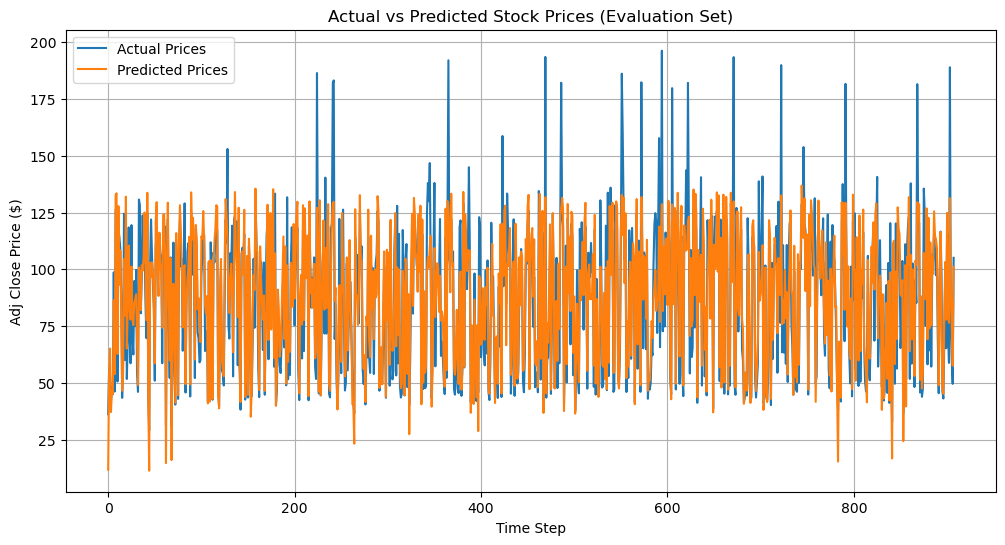

Current Learning Rate: 0.000010
Epoch 2
-------------------------------
loss: 0.010217  [  128/ 5150]
loss: 0.008666  [ 1408/ 5150]
loss: 0.009487  [ 2688/ 5150]
loss: 0.008093  [ 3968/ 5150]
loss: 0.009636  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 222.4910
Root Mean Squared Error (RMSE): 14.9161
Mean Absolute Error (MAE): 11.1085
R-squared (R2 Score): 0.7944


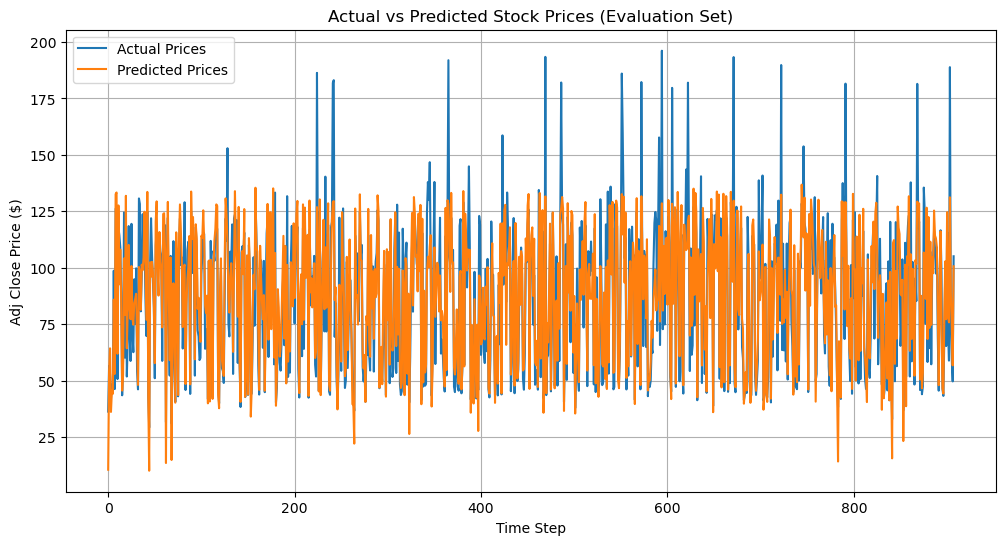

Current Learning Rate: 0.000010
Epoch 3
-------------------------------
loss: 0.009471  [  128/ 5150]
loss: 0.010678  [ 1408/ 5150]
loss: 0.009745  [ 2688/ 5150]
loss: 0.013376  [ 3968/ 5150]
loss: 0.006531  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 222.7309
Root Mean Squared Error (RMSE): 14.9242
Mean Absolute Error (MAE): 10.9976
R-squared (R2 Score): 0.7942


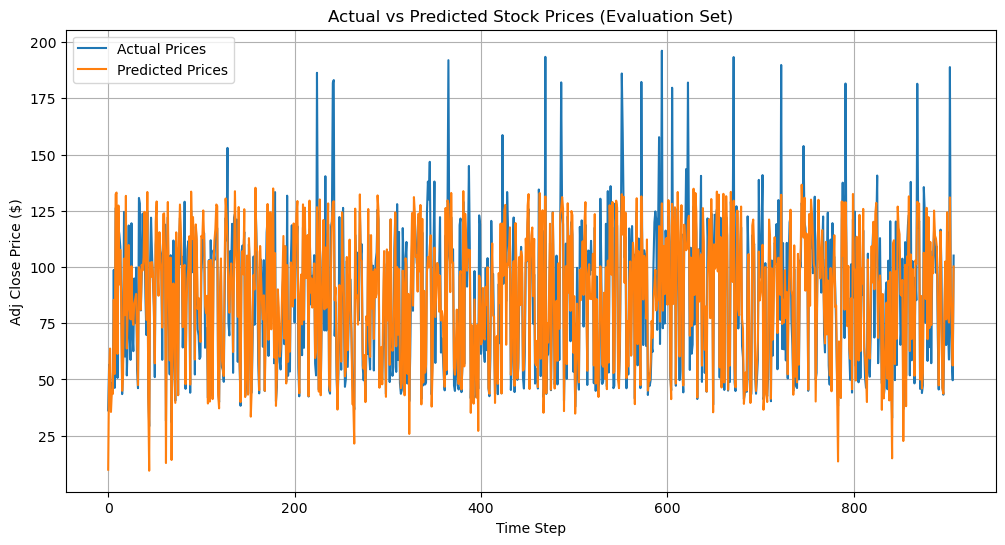

Current Learning Rate: 0.000010
Epoch 4
-------------------------------
loss: 0.007811  [  128/ 5150]
loss: 0.009580  [ 1408/ 5150]
loss: 0.009176  [ 2688/ 5150]
loss: 0.012901  [ 3968/ 5150]
loss: 0.007226  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 223.5467
Root Mean Squared Error (RMSE): 14.9515
Mean Absolute Error (MAE): 10.9030
R-squared (R2 Score): 0.7934


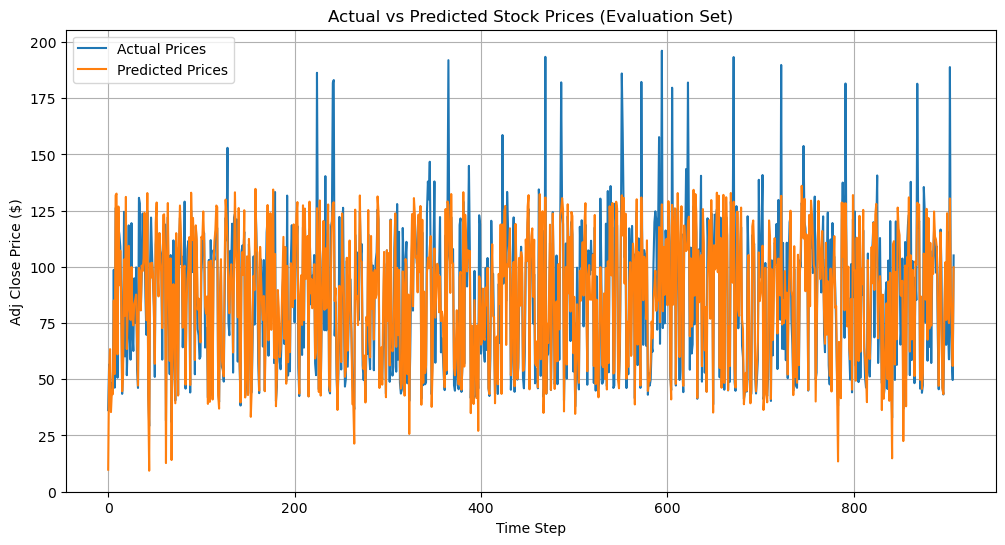

Current Learning Rate: 0.000010
Epoch 5
-------------------------------
loss: 0.007835  [  128/ 5150]
loss: 0.007594  [ 1408/ 5150]
loss: 0.007556  [ 2688/ 5150]
loss: 0.012387  [ 3968/ 5150]
loss: 0.008638  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 222.7427
Root Mean Squared Error (RMSE): 14.9246
Mean Absolute Error (MAE): 10.9752
R-squared (R2 Score): 0.7942


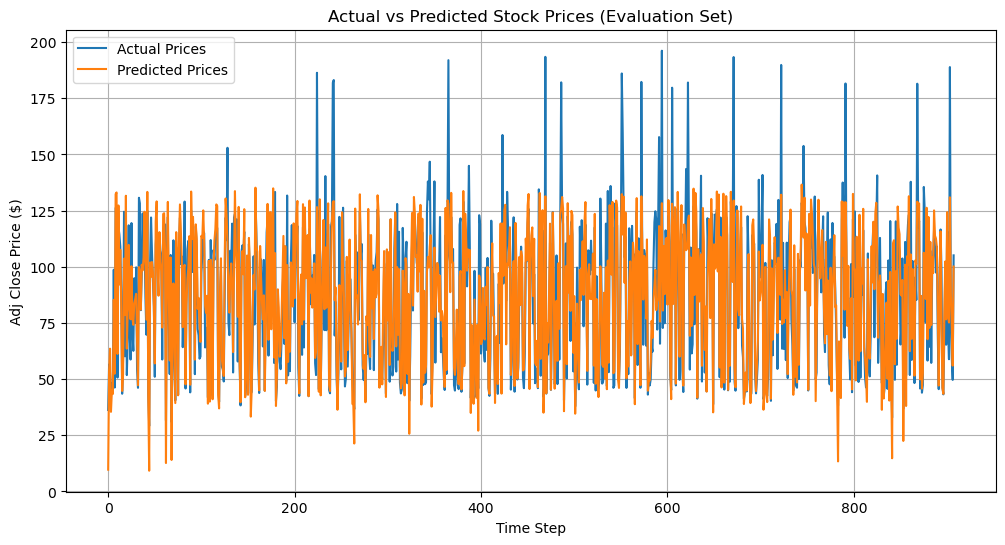

Current Learning Rate: 0.000010
Epoch 6
-------------------------------
loss: 0.009620  [  128/ 5150]
loss: 0.009173  [ 1408/ 5150]
loss: 0.011222  [ 2688/ 5150]
loss: 0.009188  [ 3968/ 5150]
loss: 0.009771  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 222.8610
Root Mean Squared Error (RMSE): 14.9285
Mean Absolute Error (MAE): 11.0029
R-squared (R2 Score): 0.7941


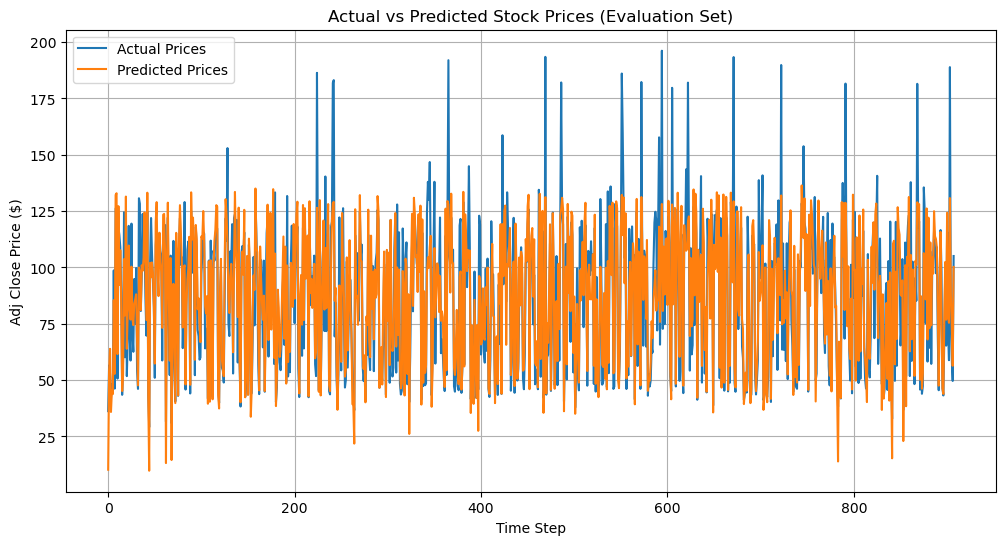

Current Learning Rate: 0.000010
Epoch 7
-------------------------------
loss: 0.007258  [  128/ 5150]
loss: 0.011250  [ 1408/ 5150]
loss: 0.008991  [ 2688/ 5150]
loss: 0.009043  [ 3968/ 5150]
loss: 0.010627  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 224.6716
Root Mean Squared Error (RMSE): 14.9890
Mean Absolute Error (MAE): 10.8160
R-squared (R2 Score): 0.7924


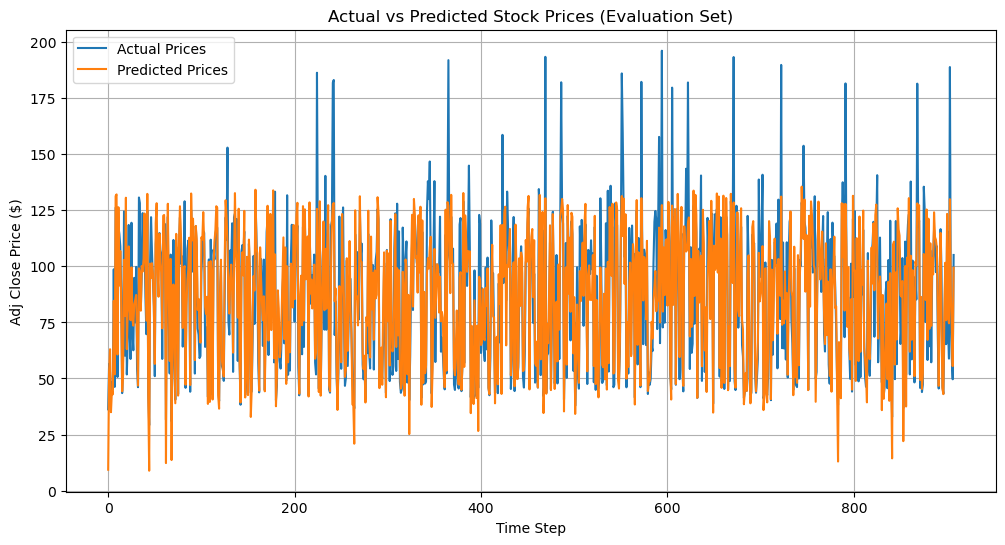

Current Learning Rate: 0.000010
Epoch 8
-------------------------------
loss: 0.010604  [  128/ 5150]
loss: 0.009880  [ 1408/ 5150]
loss: 0.013972  [ 2688/ 5150]
loss: 0.008986  [ 3968/ 5150]
loss: 0.014499  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 222.1254
Root Mean Squared Error (RMSE): 14.9039
Mean Absolute Error (MAE): 11.0828
R-squared (R2 Score): 0.7948


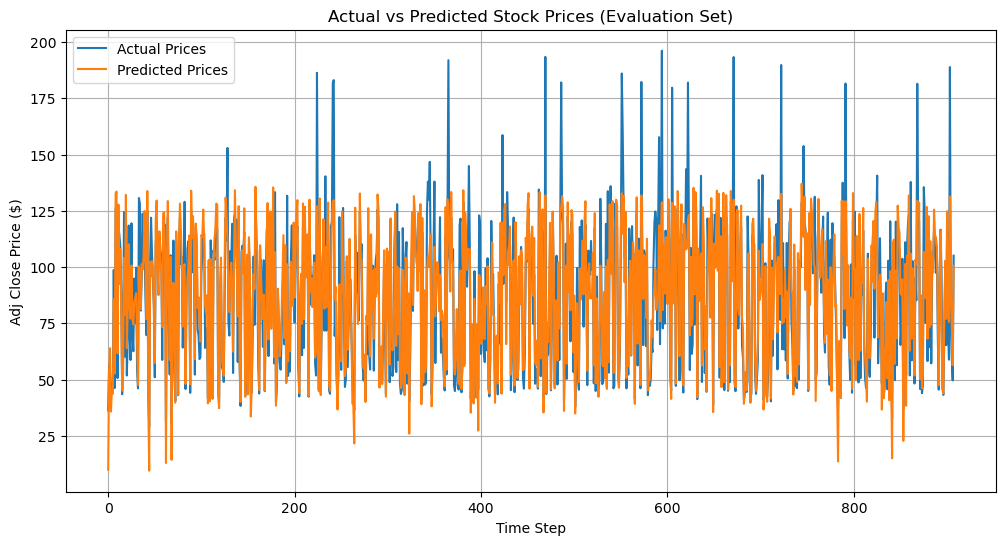

Current Learning Rate: 0.000010
Epoch 9
-------------------------------
loss: 0.007853  [  128/ 5150]
loss: 0.008774  [ 1408/ 5150]
loss: 0.010108  [ 2688/ 5150]
loss: 0.006140  [ 3968/ 5150]
loss: 0.013791  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 222.6843
Root Mean Squared Error (RMSE): 14.9226
Mean Absolute Error (MAE): 11.0217
R-squared (R2 Score): 0.7942


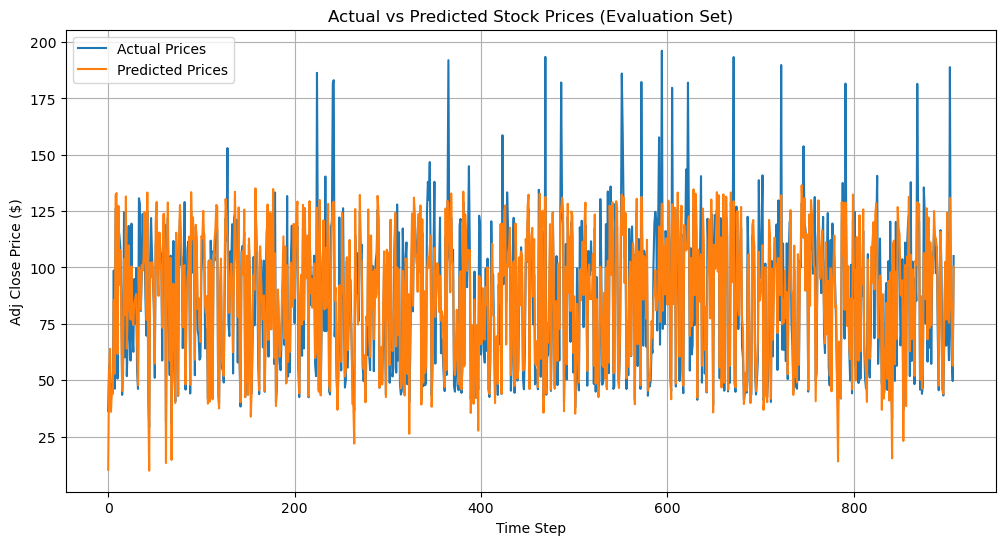

Current Learning Rate: 0.000010
Epoch 10
-------------------------------
loss: 0.011423  [  128/ 5150]
loss: 0.011639  [ 1408/ 5150]
loss: 0.010392  [ 2688/ 5150]
loss: 0.007658  [ 3968/ 5150]
loss: 0.015621  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 225.1479
Root Mean Squared Error (RMSE): 15.0049
Mean Absolute Error (MAE): 10.7898
R-squared (R2 Score): 0.7920


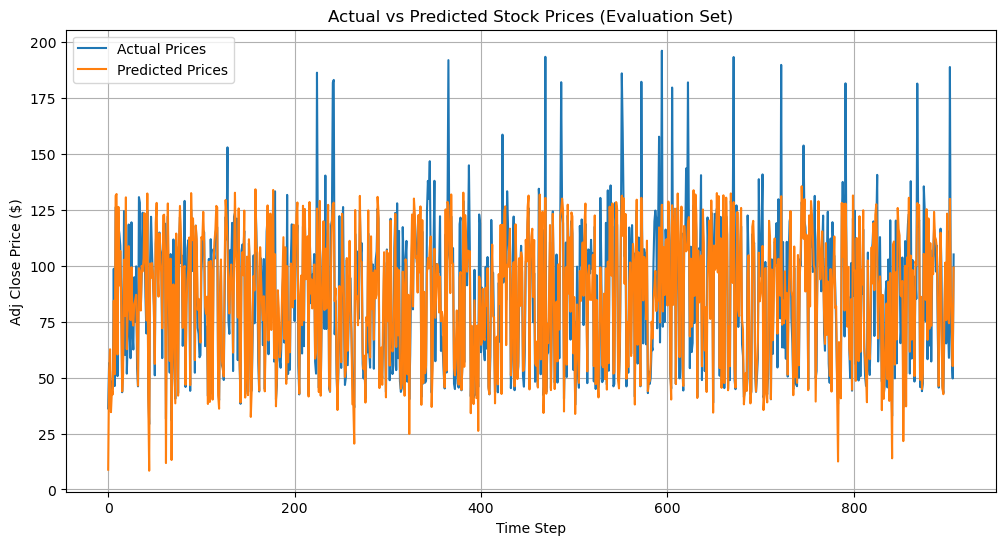

Current Learning Rate: 0.000010
Epoch 11
-------------------------------
loss: 0.008875  [  128/ 5150]
loss: 0.009411  [ 1408/ 5150]
loss: 0.010109  [ 2688/ 5150]
loss: 0.008591  [ 3968/ 5150]
loss: 0.021853  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 223.5735
Root Mean Squared Error (RMSE): 14.9524
Mean Absolute Error (MAE): 10.8972
R-squared (R2 Score): 0.7934


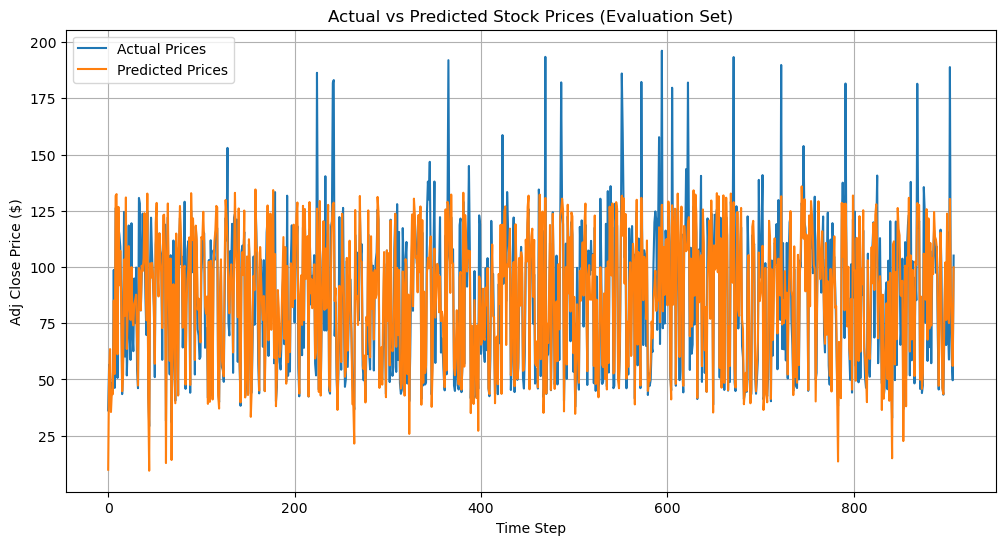

Current Learning Rate: 0.000010
Epoch 12
-------------------------------
loss: 0.009059  [  128/ 5150]
loss: 0.008528  [ 1408/ 5150]
loss: 0.009781  [ 2688/ 5150]
loss: 0.009018  [ 3968/ 5150]
loss: 0.006969  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 223.6177
Root Mean Squared Error (RMSE): 14.9539
Mean Absolute Error (MAE): 10.8806
R-squared (R2 Score): 0.7934


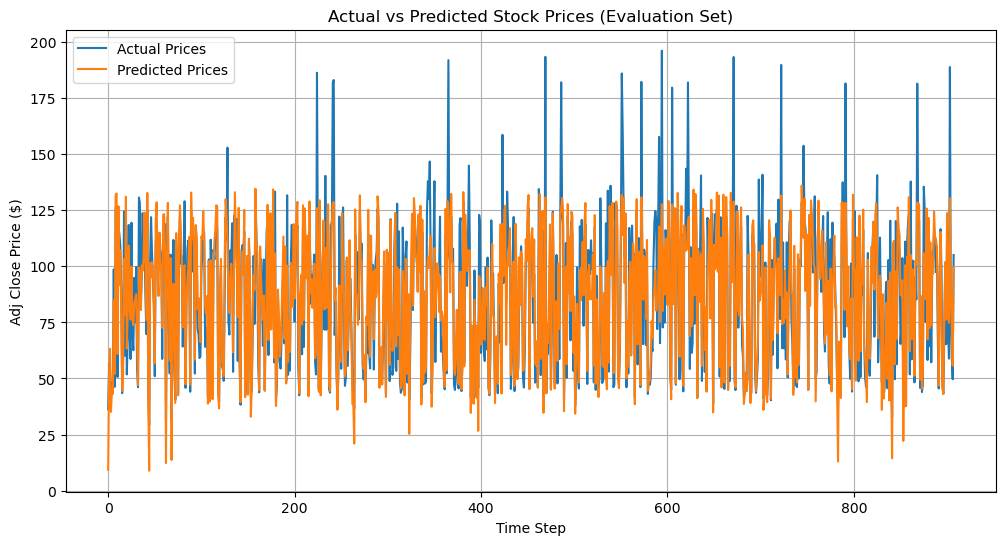

Current Learning Rate: 0.000010
Epoch 13
-------------------------------
loss: 0.007484  [  128/ 5150]
loss: 0.008194  [ 1408/ 5150]
loss: 0.008893  [ 2688/ 5150]
loss: 0.006287  [ 3968/ 5150]
loss: 0.014954  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 222.8116
Root Mean Squared Error (RMSE): 14.9269
Mean Absolute Error (MAE): 11.0070
R-squared (R2 Score): 0.7941


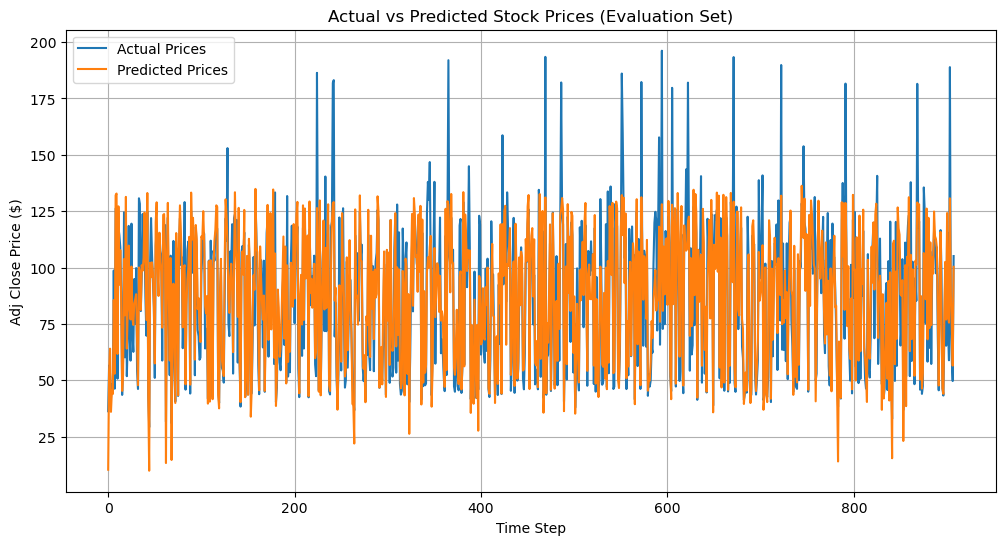

Current Learning Rate: 0.000010
Epoch 14
-------------------------------
loss: 0.006904  [  128/ 5150]
loss: 0.010480  [ 1408/ 5150]
loss: 0.007973  [ 2688/ 5150]
loss: 0.010534  [ 3968/ 5150]
loss: 0.004817  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 223.5068
Root Mean Squared Error (RMSE): 14.9501
Mean Absolute Error (MAE): 10.8807
R-squared (R2 Score): 0.7935


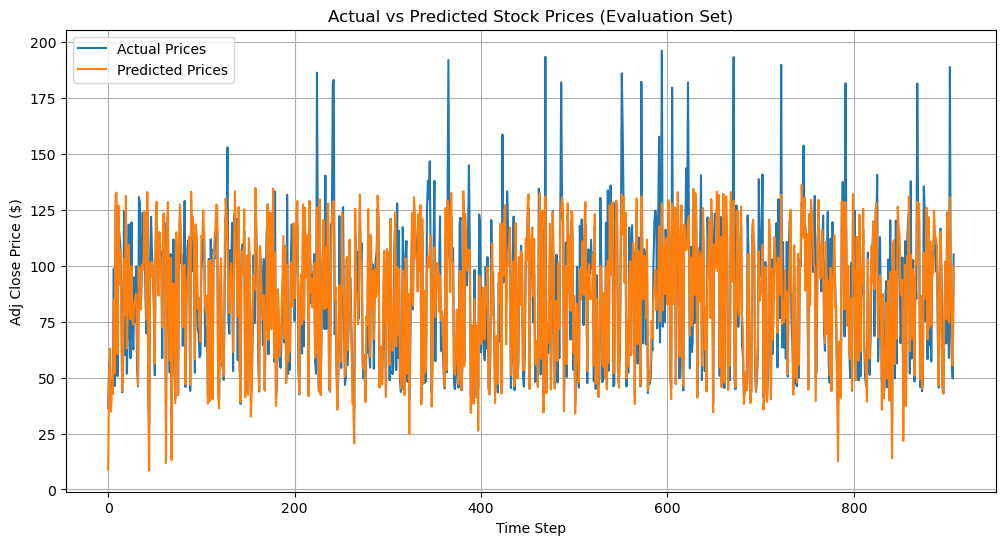

Current Learning Rate: 0.000010
Epoch 15
-------------------------------
loss: 0.011584  [  128/ 5150]
loss: 0.010034  [ 1408/ 5150]
loss: 0.008053  [ 2688/ 5150]
loss: 0.008686  [ 3968/ 5150]
loss: 0.010311  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 222.1249
Root Mean Squared Error (RMSE): 14.9039
Mean Absolute Error (MAE): 11.2021
R-squared (R2 Score): 0.7948


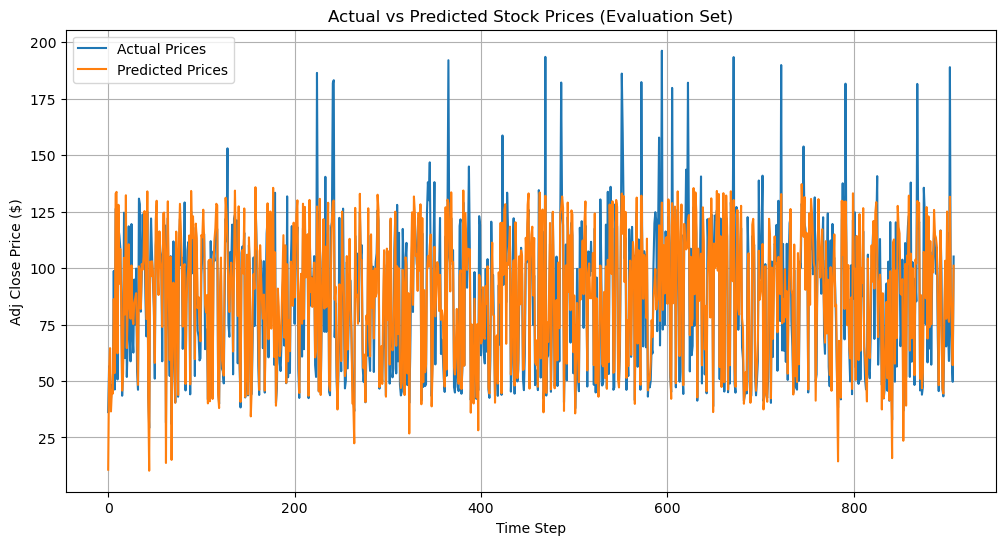

Current Learning Rate: 0.000010
Epoch 16
-------------------------------
loss: 0.009870  [  128/ 5150]
loss: 0.012060  [ 1408/ 5150]
loss: 0.010070  [ 2688/ 5150]
loss: 0.009996  [ 3968/ 5150]
loss: 0.006806  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 227.8164
Root Mean Squared Error (RMSE): 15.0936
Mean Absolute Error (MAE): 10.6725
R-squared (R2 Score): 0.7895


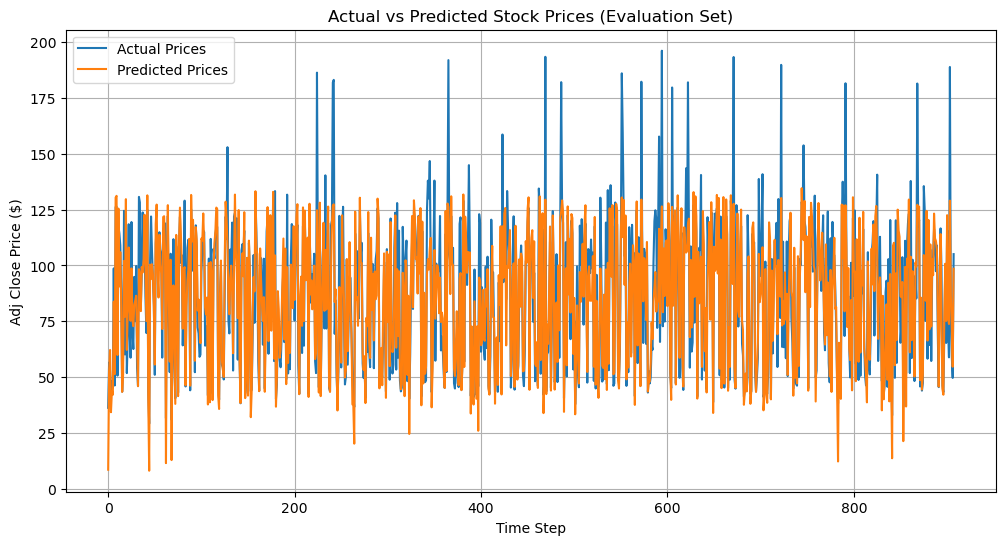

Current Learning Rate: 0.000010
Epoch 17
-------------------------------
loss: 0.010882  [  128/ 5150]
loss: 0.009606  [ 1408/ 5150]
loss: 0.011823  [ 2688/ 5150]
loss: 0.008668  [ 3968/ 5150]
loss: 0.011933  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 221.8361
Root Mean Squared Error (RMSE): 14.8942
Mean Absolute Error (MAE): 11.2388
R-squared (R2 Score): 0.7950


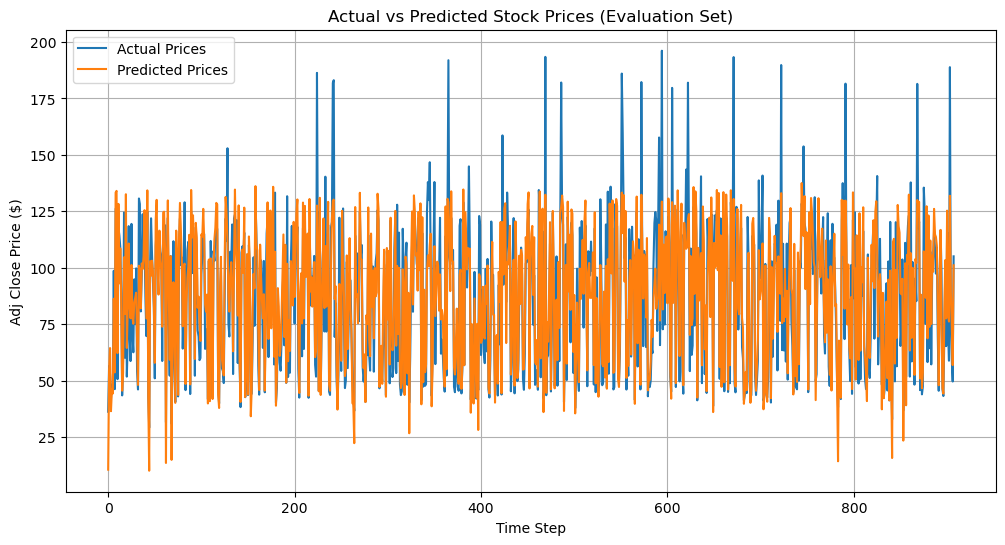

Current Learning Rate: 0.000010
Epoch 18
-------------------------------
loss: 0.010056  [  128/ 5150]
loss: 0.009752  [ 1408/ 5150]
loss: 0.009681  [ 2688/ 5150]
loss: 0.010563  [ 3968/ 5150]
loss: 0.018108  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 226.0656
Root Mean Squared Error (RMSE): 15.0355
Mean Absolute Error (MAE): 10.7359
R-squared (R2 Score): 0.7911


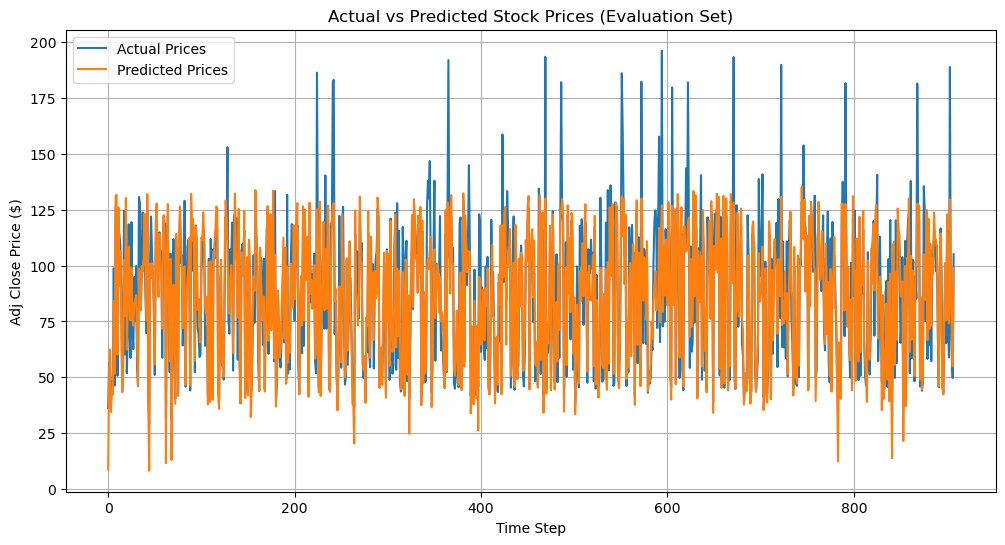

Current Learning Rate: 0.000010
Epoch 19
-------------------------------
loss: 0.009545  [  128/ 5150]
loss: 0.014676  [ 1408/ 5150]
loss: 0.010168  [ 2688/ 5150]
loss: 0.007664  [ 3968/ 5150]
loss: 0.005091  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 223.0279
Root Mean Squared Error (RMSE): 14.9341
Mean Absolute Error (MAE): 10.9151
R-squared (R2 Score): 0.7939


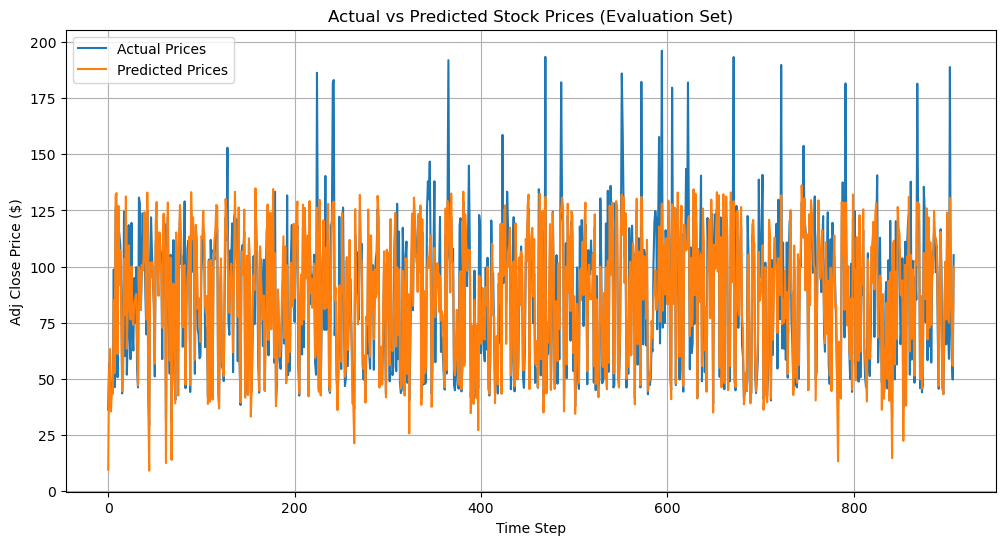

Current Learning Rate: 0.000010
Epoch 20
-------------------------------
loss: 0.010406  [  128/ 5150]
loss: 0.009246  [ 1408/ 5150]
loss: 0.007671  [ 2688/ 5150]
loss: 0.007568  [ 3968/ 5150]
loss: 0.006317  [ 5150/ 5150]

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 224.2600
Root Mean Squared Error (RMSE): 14.9753
Mean Absolute Error (MAE): 10.8212
R-squared (R2 Score): 0.7928


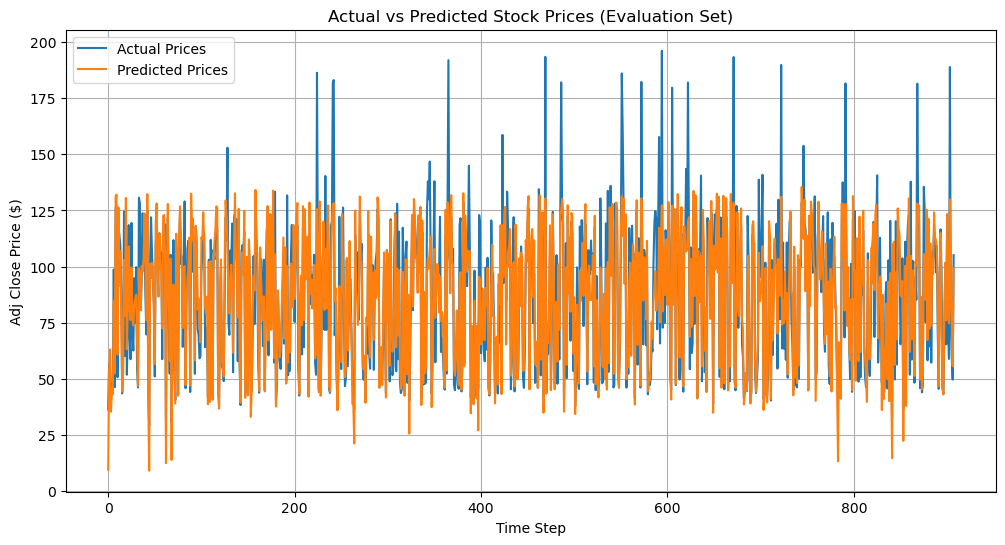

Current Learning Rate: 0.000010
Done!


In [94]:
epochs = 20
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
for iteration in range(epochs):
    print(f"Epoch {iteration+1}\n-------------------------------")
    train_loop(training_dataloader,model,criterion,optimizer)
    evaluate_loop(evaluate_dataloader,model)
    scheduler.step()
    #display the current learning rate 
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr:.6f}")
print("Done!")